# MultiLayer Perceptron

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import sklearn
import sklearn.datasets

In [2]:
def load_mnist():
    mnist = fetch_openml('mnist_784')
    X,y = mnist['data'], mnist['target']
    X_train,y_train,X_test,y_test = X[0:60000],y[0:60000],X[60001:],y[60001:]
    y_train = y_train.reshape(len(y_train),1).astype(np.int)
    y_test = y_test.reshape(len(y_test),1).astype(np.int)
    return X_train, y_train, X_test, y_test

### Propagation methods

In [3]:
class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

### Activation Functions

In [4]:
class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff
    
class Relu:
    def forward(self, X):
        if np.isscalar(X):
            result = np.max((X, 0))
        else:
            zero_aux = np.zeros(X.shape)
            meta_x = np.stack((X , zero_aux), axis = -1)
            result = np.max(meta_x, axis = -1)
        return result
    
    def backward(self, X, top_diff):
        result = 1.0 * (X > 0)
        result = np.clip(result,1e-15,1-1e-15)
        return (result) * top_diff
    
class Linear:
    def forward(self, X):
        return X
    
    def backward(self, X, top_diff):
        return top_diff
    
def get_act_fn(activation):
    if activation == 'sigmoid':
        act = Sigmoid()
    elif activation == 'relu':
        act = Relu()
    elif activation == 'tanh':
        act = Tanh()
    elif activation == 'linear':
        act = Linear()
    return act

### Softmax Functions

In [5]:
class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X.astype(np.float))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs = np.clip(probs,1e-15,1-1e-15)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs = np.clip(probs,1e-15,1-1e-15)
        probs[range(num_examples), y] -= 1
        return probs

### Nueral Net

In [6]:
class Nueral_Net:
    def __init__(self, num_layers, layers_dim, iterations=300, learning_rate=0.1, activation='sigmoid'):
        self.layers_dim = layers_dim
        self.num_layers = num_layers
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.activation = activation
        self.activation_fn = get_act_fn(self.activation)
        self.bias = []
        self.weights = []
        self.loss = []
        for i in range(self.num_layers-1):
            self.weights.append(0.1*np.random.normal(0,1,size=(self.layers_dim[i], self.layers_dim[i+1])))
            self.bias.append(np.zeros((1, self.layers_dim[i+1])))
#             self.weights.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
#             self.bias.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

#             print("Weights",i,self.weights)
#             print("Bias",i,self.bias)
                             
    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        act_layer = self.activation_fn
        output_layer = Softmax()

        inp = X
        for i in range(len(self.weights)):
            mul = mulGate.forward(self.weights[i], inp)
            add = addGate.forward(mul, self.bias[i])
            inp = act_layer.forward(add)

        return output_layer.loss(inp, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        act_layer = self.activation_fn
        output_layer = Softmax()

        inp = X
        for i in range(len(self.weights)):
            mul = mulGate.forward(self.weights[i], inp)
            add = addGate.forward(mul, self.bias[i])
            inp = act_layer.forward(add)

        probs = output_layer.predict(inp)
        return np.argmax(probs, axis=1)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y == y_pred) / len(y)

    def fit(self, X, y, verbose = True):
        mulGate = MultiplyGate()
        addGate = AddGate()
        act_layer = self.activation_fn
        output_layer = Softmax()
                          
        for epoch in range(self.iterations):
            # Forward propagation
            inp = X
            forward = [(None, None, inp)]
            for i in range(len(self.weights)):
                mul = mulGate.forward(self.weights[i], inp)
                add = addGate.forward(mul, self.bias[i])
                inp = act_layer.forward(add)
                forward.append((mul, add, inp))

            # Back propagation
            bact = output_layer.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = act_layer.backward(forward[i][1], bact)
                db, dmul = addGate.backward(forward[i][0], self.bias[i-1], dadd)
                dW, bact = mulGate.backward(self.weights[i-1], forward[i-1][2], dmul)

                self.bias[i-1] += -self.learning_rate * db
                self.weights[i-1] += -self.learning_rate * dW
                
            loss = self.calculate_loss(X, y)
            self.loss.append(loss)
            if verbose:
                print("Loss after iteration %i: %f" %(epoch+1, loss))

In [8]:
np.random.seed(0)
X_train, y_train = sklearn.datasets.make_moons(200, noise=0.20)

In [9]:
layers = 3
layers_dim = [2, 3, 2]

## Neural Net Scores and Losses

In [7]:
mnist = fetch_openml('mnist_784')
X,y = mnist['data'], mnist['target']
X_train,y_train,X_test,y_test = X[0:60000],y[0:60000],X[60001:],y[60001:]
y_train = y_train.reshape(len(y_train),1).astype(np.int)
y_test = y_test.reshape(len(y_test),1).astype(np.int)
layers = 5
layers_dim = [28*28, 256, 128, 64, 10]

### ReLU

Loss after iteration 1: 0.693147
Loss after iteration 2: 0.693147
Loss after iteration 3: 0.693147
Loss after iteration 4: 0.693147
Loss after iteration 5: 0.693147
Loss after iteration 6: 0.693147
Loss after iteration 7: 0.693147
Loss after iteration 8: 0.693147
Loss after iteration 9: 0.693147
Loss after iteration 10: 0.693147
Loss after iteration 11: 0.693147
Loss after iteration 12: 0.693147
Loss after iteration 13: 0.693147
Loss after iteration 14: 0.693147
Loss after iteration 15: 0.693147
Loss after iteration 16: 0.693147
Loss after iteration 17: 0.693147
Loss after iteration 18: 0.693147
Loss after iteration 19: 0.693147
Loss after iteration 20: 0.693147
Loss after iteration 21: 0.693147
Loss after iteration 22: 0.693147
Loss after iteration 23: 0.693147
Loss after iteration 24: 0.693147
Loss after iteration 25: 0.693147
Loss after iteration 26: 0.693147
Loss after iteration 27: 0.693147
Loss after iteration 28: 0.693147
Loss after iteration 29: 0.693147
Loss after iteration 30

0.5

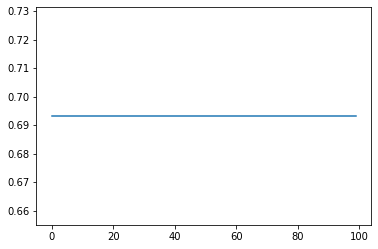

In [10]:
mlp1 = Nueral_Net(layers, layers_dim, iterations=100, learning_rate=0.01, activation='relu')
mlp1.fit(X_train, y_train)
loss1 = mlp1.loss
plt.plot(loss1)
mlp1.score(X_train,y_train)

### Sigmoid

Loss after iteration 1: 0.690530
Loss after iteration 2: 0.686931
Loss after iteration 3: 0.679165
Loss after iteration 4: 0.663980
Loss after iteration 5: 0.639077
Loss after iteration 6: 0.606906
Loss after iteration 7: 0.574783
Loss after iteration 8: 0.548436
Loss after iteration 9: 0.528638
Loss after iteration 10: 0.513902
Loss after iteration 11: 0.502717
Loss after iteration 12: 0.494032
Loss after iteration 13: 0.487167
Loss after iteration 14: 0.481666
Loss after iteration 15: 0.477208
Loss after iteration 16: 0.473557
Loss after iteration 17: 0.470533
Loss after iteration 18: 0.468000
Loss after iteration 19: 0.465854
Loss after iteration 20: 0.464016
Loss after iteration 21: 0.462427
Loss after iteration 22: 0.461040
Loss after iteration 23: 0.459819
Loss after iteration 24: 0.458738
Loss after iteration 25: 0.457774
Loss after iteration 26: 0.456911
Loss after iteration 27: 0.456134
Loss after iteration 28: 0.455433
Loss after iteration 29: 0.454797
Loss after iteration 30

0.845

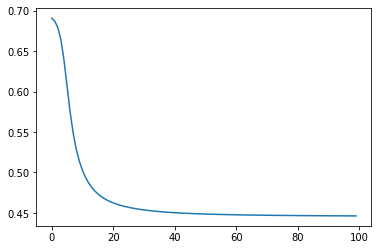

In [11]:
mlp2 = Nueral_Net(layers, layers_dim, iterations=100, learning_rate=0.1, activation='sigmoid')
mlp2.fit(X_train, y_train)
loss2 = mlp2.loss
plt.plot(loss2)
mlp2.score(X_train,y_train)

### Linear

Loss after iteration 1: 0.426019
Loss after iteration 2: 5.029175
Loss after iteration 3: nan
Loss after iteration 4: nan
Loss after iteration 5: nan
Loss after iteration 6: nan
Loss after iteration 7: nan
Loss after iteration 8: nan
Loss after iteration 9: nan
Loss after iteration 10: nan
Loss after iteration 11: nan
Loss after iteration 12: nan
Loss after iteration 13: nan
Loss after iteration 14: nan
Loss after iteration 15: nan
Loss after iteration 16: nan
Loss after iteration 17: nan
Loss after iteration 18: nan
Loss after iteration 19: nan
Loss after iteration 20: nan
Loss after iteration 21: nan
Loss after iteration 22: nan
Loss after iteration 23: nan
Loss after iteration 24: nan
Loss after iteration 25: nan
Loss after iteration 26: nan
Loss after iteration 27: nan
Loss after iteration 28: nan
Loss after iteration 29: nan
Loss after iteration 30: nan
Loss after iteration 31: nan
Loss after iteration 32: nan
Loss after iteration 33: nan
Loss after iteration 34: nan
Loss after it

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


0.5

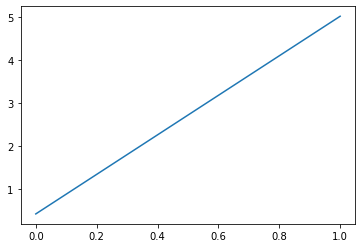

In [12]:
mlp3 = Nueral_Net(layers, layers_dim, iterations=100, learning_rate=0.1, activation='linear')
mlp3.fit(X_train, y_train)
loss3 = mlp3.loss
plt.plot(loss3)
mlp3.score(X_train,y_train)

### TanH

Loss after iteration 1: 0.453881
Loss after iteration 2: 0.576459
Loss after iteration 3: 0.674383
Loss after iteration 4: 0.507302
Loss after iteration 5: 0.470698
Loss after iteration 6: 0.412797
Loss after iteration 7: 0.473220
Loss after iteration 8: 0.610532
Loss after iteration 9: 0.472728
Loss after iteration 10: 0.424897
Loss after iteration 11: 0.434307
Loss after iteration 12: 0.408334
Loss after iteration 13: 0.392901
Loss after iteration 14: 0.401160
Loss after iteration 15: 0.384620
Loss after iteration 16: 0.369432
Loss after iteration 17: 0.345717
Loss after iteration 18: 0.350915
Loss after iteration 19: 0.346600
Loss after iteration 20: 0.358872
Loss after iteration 21: 0.358056
Loss after iteration 22: 0.362610
Loss after iteration 23: 0.352603
Loss after iteration 24: 0.354383
Loss after iteration 25: 0.338840
Loss after iteration 26: 0.334663
Loss after iteration 27: 0.337657
Loss after iteration 28: 0.336180
Loss after iteration 29: 0.340909
Loss after iteration 30

0.86

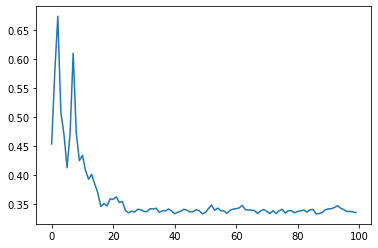

In [13]:
mlp4 = Nueral_Net(layers, layers_dim, iterations=100, learning_rate=0.1, activation='tanh')
mlp4.fit(X_train, y_train)
loss4 = mlp4.loss
plt.plot(loss4)
mlp4.score(X_train,y_train)

### Saving Weights

In [16]:
import pickle

data = {'relu': mlp1,'sigmoid':mlp2,'linear':mlp3,'tanh':mlp3}

with open('models.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)